# Solving Contract Classification challenge 

* Since the instructor claims that we can reach above 90% accuracy without using ML techniques, then let's give it a try.
* --->The code was not optimized for running time <---

* let's start with importing all the necessary libraries

In [375]:
import sys
import numpy as np 
from functools import partial
from zipfile import ZipFile
import pandas as pd
from sklearn.metrics import confusion_matrix
sys.path.append('../src/')
# %matplotlib inline
import re
from uatt import submit

Now I'm defining some useful function

In [376]:
def theMostRepitable(dic):
    TwentyMostRepitableWors = []
    for i in range(20):
        val = max(dic.values())
        
        for j in dic.keys():
            if dic[j] == val:
                key = j
                break
            
        TwentyMostRepitableWors.append(key)
        dic.pop(key)
        
    return TwentyMostRepitableWors

* My personal details 

In [377]:
my_submit = partial(submit, "Yaniv Cohen", "Elbit", "yanivavoda@gmail.com", "0524321552")

* Now, let's read the data from a zip file provided by the instructor. 

Note: I am reading now only the trainig data (for now) and taking a look over the structure of the data.

In [378]:
## Read the data 
data = []
with ZipFile("../data/data.zip") as z:
    for fname in z.namelist():
        if not fname.endswith('.txt') or not fname.startswith('data'):
            continue
        content = z.read(fname).decode('utf8')
        label, idx = fname[5:-4].split('-', 1)
        data.append((idx,label,content,))
df_train0 = pd.DataFrame(data, columns=("id", "label", "content"))
print(df_train0.sample(10))
print("The size of the training data is: %.i" % len(df_train0))

         id       label                                            content
2841  22250         rsu  Exhibit 10.4 \n\nNMT MEDICAL, INC. \n\n\n  \nN...
2721  21050         rsu  Exhibit 99.3 \n\n\n\nWHEREAS, Beverly N. Hawki...
2500  18840         rsu  EXHIBIT 10.1\n\nRestricted Stock Agreement One...
111   01120         SPA  EXHIBIT 10.1\n\n\n\nThis Stock Purchase Agreem...
2081  16040  employment  Exhibit 10.6\n\n\n\nTHIS EMPLOYMENT AGREEMENT ...
3257  26410         rsu  Exhibit 10.21 \n\n\n\nTHIS AGREEMENT, made as ...
3189  25730         rsu  Exhibit 10.5  \n\n\nPINNACLE FINANCIAL PARTNER...
93    00940         SPA    \n\n\n  \n\n\n\n\n  \n\n\nTHIS STOCK PURCHAS...
3305  26890         rsu  Exhibit 10.3 \n\nAUXILIUM PHARMACEUTICALS, INC...
324   40910      bylaws  * * *\n\nAMENDED AND RESTATED\n\n\n\nOF\n\nWHI...
The size of the training data is: 4427


* Let's take a look at the distribution of the data based on the contract class.

<AxesSubplot:>

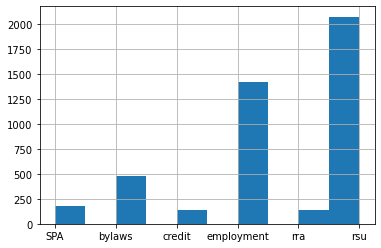

In [379]:

### PLot the distribution 
df_train0["label"].hist()

* Next, let's see if we have some missing data in our dataset. Additionally, let's examine the uniqueness of each column. (As we can see there is no duplication nor missing data)

In [380]:
print("\nCheck if you have None in the data:")
print(pd.isnull(df_train).sum())
# check uniqness
col = df_train0.columns.values

for head in df_train0.columns.values:
    
    print('unique values of %s: %i, dataType: %s' % (head, df_train0[head].nunique(), type(df_train0[head][1])))


Check if you have None in the data:
id         0
label      0
content    0
dtype: int64
unique values of id: 4427, dataType: <class 'str'>
unique values of label: 6, dataType: <class 'str'>
unique values of content: 4396, dataType: <class 'str'>


* As we can see we have 6 classes, 

* Next, let's shuffle the training data into train and validation sets. This move is necessary to check ourselves.

In [381]:
x = len(df_train0)
df_train0 = df_train0.sample(frac=1).reset_index(drop=True) ### <---shuffle step

df_train = df_train = df_train0.copy(deep = True)  
# see the warning note at the end of this notebook , df_train0.iloc[:int(0.9*x)]
df_train_validation = df_train0.iloc[int(0.9*x):]

## The core of the proposed technique

* The technique presented here is based on finding unique words for each class. Those words will be used as a fingerprint for our classification. In other words, for each class, we'll have a unique vector that contains the most frequent words of this class, and which are not presented in any other class. 


* Mathematically:

$\forall w_{i}^{j} \in W^{j}$, $w_{i}^{j} \notin W  = \{W^{c} | c \neq j \}$ 

where $j$ is the class number, $j \in \{1,2,3,4,5,6\}$, $i$ is the word's index in the vector of the class, $i\in\{1,...,20\}$, and $W^{j}$ is a vector of 20 unique words of the class j.

In [382]:
### check the most repitable words
print("Analyzing unique words for each class... \n")
all_labels = sorted(df_train["label"].unique())
all_classes_dic = {}
for label_i in all_labels :
    print("Cheking unique words for the class: ",label_i)
    f = df_train.loc[(df_train['label'] == label_i)]
    f.reset_index(drop = True, inplace = True)

    counterDictionary = {} 
            
    for i in range(len(f)):
        str_i = f.iloc[i]["content"]
        list_of_words = str_i.split()
        words_p = []  
        for j in list_of_words:
            try:
                float(j)
            except:
                
                if j not in ["a", "The","the", "and", "is", "are", "of", "by", "this", "shall", 
                             "as", "with", "such"] and j not in words_p:
                    
                    counterDictionary[j] = counterDictionary.get(j, 0) + 1
                    
                words_p.append(j)
    
    all_classes_dic[label_i] = counterDictionary
    
count  = 0  
vec_keys_label = list(all_classes_dic.keys()) 
d_new_of_optimal_words= {} 

for ij in range(len(all_classes_dic.keys())):
    label_i = vec_keys_label[ij]
    dic = all_classes_dic[label_i]
    all_other_keys = vec_keys_label[:ij] + vec_keys_label[ij+1:]
    d = {}
    value = 0

    [d.update(all_classes_dic[kj]) for kj in all_other_keys]
    
    d_keys_unique = {}
    for key2 in dic.keys():
        if key2 not in  d.keys():

            if dic[key2] >= 5:
                d_keys_unique[key2] = dic[key2]
            
            if value < dic[key2]:
                optimal_key = key2
                value = dic[key2]
                
    d_new_of_optimal_words[label_i] = d_keys_unique  #(optimal_key, value)

print("Finish!")

Analyzing unique words for each class... 

Cheking unique words for the class:  SPA
Cheking unique words for the class:  bylaws
Cheking unique words for the class:  credit
Cheking unique words for the class:  employment
Cheking unique words for the class:  rra
Cheking unique words for the class:  rsu
Finish!


## Test step:


* Now that we have for each class 20 unique words, let's make some predictions over our validation set.
* The idea is as follows, for each class I will check how many unique words are present in the given contract, the class with the highest match will be defined as the class of the examined contract. In the case of zero matches for all 6 classes, I am going to classify it as "rsu" class based on the fact that it is the most common contract class in our data.

* Note: Since 'rra' class is very rare, then I will define 'rra' class only if we reach higher than 25% match.

In [383]:

#### check yoursel


twenty_most_repitable_per_class = {}
classes_all = ['rsu', 'employment', 'bylaws', 'SPA', 'credit', 'rra']

for c in classes_all:
    dic = d_new_of_optimal_words[c]
    dic_per_class = theMostRepitable(dic.copy())
    twenty_most_repitable_per_class[c] =  dic_per_class

df_train_validation.reset_index(drop = True, inplace = True)
Vec = ["rsu" for l in range(len(df_train_validation))]
df_train_validation.insert(np.shape(df_train_validation)[1], "prediction", Vec )
#["label2"] = ["rsu" for l in range(len(df_train_validation))] 


for i in range(len(df_train_validation)):
        str_i = df_train_validation.iloc[i]["content"]
        list_of_words = str_i.split()
        
        ## now lets check fitting 
        value = 0
        for c in classes_all:
            dic = twenty_most_repitable_per_class[c]
            count = 0
            
            for j in dic:
                # print(j in str_i)
                wordi = ''.join(e for e in j if e.isalnum())
                # print(wordi)
                if wordi in str_i:
                    count += 1
            # print(count)   
            if value < count :
                value = float(count) 
                if c == 'rra' and count > 5:
                    df_train_validation.loc[i]["prediction"] = c
                    # print("value", value, c)
                elif c!= 'rra':
                    
                    df_train_validation.loc[i]["prediction"] = c
    

classes_all = ['rsu', 'employment', 'bylaws', 'SPA', 'credit', 'rra']
for i in range(len(df_train_validation)):
    for j in range(len(classes_all)):
        if classes_all[j] == df_train_validation.iloc[i]["label"]:
            df_train_validation.iloc[i]["label"] = j
        if classes_all[j] ==  df_train_validation.iloc[i]["prediction"]:
            df_train_validation.iloc[i]["prediction"] = j
 

print(df_train_validation.sample(10))
                




        id label                                            content prediction
307  33640     0  Exhibit 10.2\n\nQUALITY SYSTEMS, INC.\n\nOUTSI...          0
4    01720     3  Exhibit No.: 10.2  \n  \n\n\nThis Agreement, d...          3
220  27750     0  Exhibit 10.87\n\nCharles Romeo\n\nOptionee\n\n...          0
204  00200     3  REGULATION S \n\n\n\nThis Regulation S Stock P...          3
41   07160     1    \nQuickLinks \-- Click here to rapidly navig...          1
382  26570     0  Exhibit 10.2 \n\n1996 STOCK INCENTIVE PLAN OF ...          0
36   11660     1  EXHIBIT 10.1\n\n\n\n  \n\n\nThis Employment Ag...          1
126  29100     0  * * *\n\nExhibit 10.2\n\n\n\nMAGNUM HUNTER RES...          0
97   33910     0  Exhibit 10.3  \n\n\nSTANDARD FORM OF\n\nSCIENT...          0
310  09550     1  Exhibit 10.a.\n\n\n  \n\n\nBETWEEN  \n  \n\n\n...          1


* Now let's look at the accuracy of this primitive classifier, and check it's confusion matrix.

In [384]:
            
y_true = list(df_train_validation["label"])
y_pred = list(df_train_validation["prediction"])
good =0 
for m in range(len(y_pred)):
    if y_pred[m] == y_true[m]:
        good += 1
        
print("acc: ", good/len(y_pred))
print("\n confusion matrix: \n")
print(confusion_matrix(y_true, y_pred))



acc:  0.9142212189616253

 confusion matrix: 

[[181  14   3   1   0   0]
 [  0 142   0   0   0   0]
 [  5   3  40   1   0   2]
 [  0   2   0  12   0   2]
 [  2   1   0   0  10   0]
 [  2   0   0   0   0  20]]


## Let's try to make it better by using "manual mode" based on the data produced in the previous steps.

* This move is based on the most common words of  "rsu" and "bylaw" classes
* let's check again the accuracy and confusion matrix

In [385]:

df_train_validation.loc[df_train_validation["content"].str.contains("Optionee."),"prediction"] = 0 # 0 is "rsu"
df_train_validation.loc[df_train_validation["content"].str.contains("Grantee"), "prediction"] = 0 # 0 is"rsu"
df_train_validation.loc[df_train_validation["content"].str.contains("PARTICIPANT"), "prediction"] = 0 # 0 is "rsu"
df_train_validation.loc[df_train_validation["content"].str.contains("quorum", flags = re.I, regex = True),"prediction"]  = 2#'bylaws'
df_train_validation.loc[df_train_validation["content"].str.contains("Vacancies."),"prediction"]  = 2 #"bylaws"
            
y_true = list(df_train_validation["label"])
y_pred = list(df_train_validation["prediction"])

good =0 
for m in range(len(y_pred)):
    if y_pred[m] == y_true[m]:
        good += 1
        
print("acc: ", good/len(y_pred))
print("\n confusion matrix: \n")
print(confusion_matrix(y_true, y_pred))
print("\n Nice!! we have a better results! and we reach above 90%!! \n")
print("Ignore the SettingWithCopyWarning bellow!!!")

acc:  0.9232505643340858

 confusion matrix: 

[[185  10   3   1   0   0]
 [  0 141   1   0   0   0]
 [  5   3  41   1   0   1]
 [  0   2   0  12   0   2]
 [  2   1   0   0  10   0]
 [  2   0   0   0   0  20]]

 Nice!! we have a better results! and we reach above 90%!! 

Ignore the SettingWithCopyWarning bellow!!!


/home/yc/anaconda3/envs/tf_2_3/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/home/yc/anaconda3/envs/tf_2_3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/yc/anaconda3/envs/tf_2_3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

### Now let's import the test data and test our classifier
* Since the "manual mode" was a success we will apply it also on the test data

In [386]:


data = []
with ZipFile("../data/test_data.zip") as z:
    for fname in z.namelist():
        content = z.read(fname).decode('utf8')
        if not fname.endswith('.txt') or not fname.startswith('test'):
            continue
        idx = fname[5:-4]
        data.append((idx,content,))
df_test = pd.DataFrame(data, columns=("id", "content"))
df_test.sample(10)
df_test["label"] = "rsu" #### 0.7627



for i in range(len(df_test)):
        str_i = df_test.iloc[i]["content"]
        list_of_words = str_i.split()
        
        ## now lets check fitting 
        value = 0
        for c in classes_all:
            dic = twenty_most_repitable_per_class[c]
            count = 0
            
            for j in dic:
                # print(j in str_i)
                wordi = ''.join(e for e in j if e.isalnum())
                # print(wordi)
                if wordi in str_i:
                    count += 1
            # print(count)   
            if value < count :
                value = float(count) 
                if c == 'rra' and count > 5:
                    df_test.loc[i]["label"] = c
                    # print("value", value, c)
                elif c == 'credit' and count> 5:
                    df_test.loc[i]["label"] = c
                elif c!= 'rra' and count >=2:
                    
                    df_test.loc[i]["label"] = c
                
df_test.loc[df_test["content"].str.contains("Optionee."), "label"] = "rsu"
df_test.loc[df_test["content"].str.contains("Grantee"), "label"] = "rsu"
df_test.loc[df_test["content"].str.contains("PARTICIPANT"), "label"] = "rsu"
df_test.loc[df_test["content"].str.contains("quorum", flags = re.I, regex = True),"label"]  = 'bylaws'
df_test.loc[df_test["content"].str.contains("Vacancies."),"label"]  = 'bylaws'


 
submission = dict(df_test[["id","label"]].values)
submission_name = "YC"
acc = my_submit(submission_name, submission)

print("acc: ", acc)

acc:  0.90754257907543


## Let's check the Leaderboard 

In [387]:
import random, string
from IPython.display import HTML
rand_str = lambda: "".join(random.sample(string.ascii_letters,7))
HTML('<a href="https://goren.ml/uattcontract/?{k}={v}" target="_blank">Go to Leaderboard</a>'.format(k=rand_str(),v=rand_str()))

# Warning:
* Since we split our training data randomly, the results can change at each run!!
* We can avoid it by using the whole training data to produce the unique vector of words per class. (tto see how the results can change per each run, change from df_train = df_train0.copy(deep = True) to df_train = df_train0.iloc[:int(0.9*x)] )